ResNet50 model 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm as notebook_tqdm
from datetime import datetime
import numpy as np 
import pandas as pd 

from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import pandas as pd 
import numpy as np 



import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [3]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [3]:
# transforms = transforms.Compose([
#     transforms.ColorJitter(brightness = .5, hue = .3),
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3403, 0.3121, 0.3214),
#                          (0.2724, 0.2608, 0.2669)),
#     transforms.GaussianBlur(kernel_size = (5,9)),
#     transforms.RandomRotation(degrees = (0, 1))
# ])

In [4]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'train', transform=transforms, download=True)

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f463d3bc3a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f46385f7f40>)


In [5]:
# defining hyperparameters 
#epochs = 31   #the nn will train 31 times over all 50.000 images and validate itself with 12.000 images x 31  times) 
epochs = 30
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [6]:
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [7]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [8]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [9]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [10]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [11]:
# training function

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [12]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

#model = model.to('cpu')
model = model.to(device)


In [13]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

20:56:37 --- Epoch: 0	Train loss: 2.6759	Valid loss: 1.5983	Train accuracy: 55.66	Valid accuracy: 52.14
20:57:17 --- Epoch: 1	Train loss: 1.0508	Valid loss: 0.5927	Train accuracy: 87.93	Valid accuracy: 82.64
20:57:56 --- Epoch: 2	Train loss: 0.3537	Valid loss: 0.3051	Train accuracy: 96.48	Valid accuracy: 91.29
20:58:35 --- Epoch: 3	Train loss: 0.0955	Valid loss: 0.2675	Train accuracy: 97.80	Valid accuracy: 92.04
20:59:15 --- Epoch: 4	Train loss: 0.0523	Valid loss: 0.2167	Train accuracy: 98.63	Valid accuracy: 93.69
20:59:53 --- Epoch: 5	Train loss: 0.0451	Valid loss: 0.2206	Train accuracy: 98.32	Valid accuracy: 93.36
21:00:33 --- Epoch: 6	Train loss: 0.0603	Valid loss: 0.2693	Train accuracy: 97.03	Valid accuracy: 92.23
21:01:13 --- Epoch: 7	Train loss: 0.1038	Valid loss: 0.2920	Train accuracy: 96.48	Valid accuracy: 92.04
21:01:52 --- Epoch: 8	Train loss: 0.0661	Valid loss: 0.1550	Train accuracy: 98.73	Valid accuracy: 95.31
21:02:32 --- Epoch: 9	Train loss: 0.0366	Valid loss: 0.1690	Trai

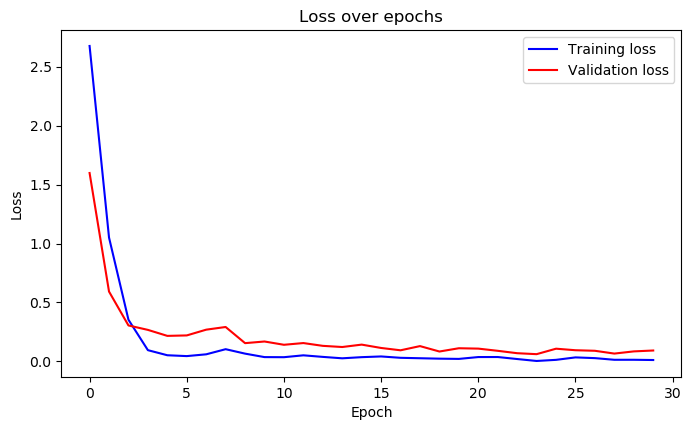

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

In [16]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [18]:

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classe
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)


Accuracy: 0.85

Micro Precision: 0.85
Micro Recall: 0.85
Micro F1-score: 0.85

Macro Precision: 0.82
Macro Recall: 0.79
Macro F1-score: 0.79

Weighted Precision: 0.86
Weighted Recall: 0.85
Weighted F1-score: 0.85

Classification Report

                                  precision    recall  f1-score   support

          0:Speed limit (20km/h)       0.72      0.35      0.47        60
          1:Speed limit (30km/h)       0.84      0.85      0.84       720
          2:Speed limit (50km/h)       0.73      0.95      0.82       750
          3:Speed limit (60km/h)       0.95      0.72      0.82       450
          4:Speed limit (70km/h)       0.96      0.84      0.90       660
          5:Speed limit (80km/h)       0.70      0.77      0.73       630
   6:End of speed limit (80km/h)       0.98      0.55      0.70       150
         7:Speed limit (100km/h)       0.88      0.74      0.81       450
         8:Speed limit (120km/h)       0.75      0.87      0.81       450
                    9

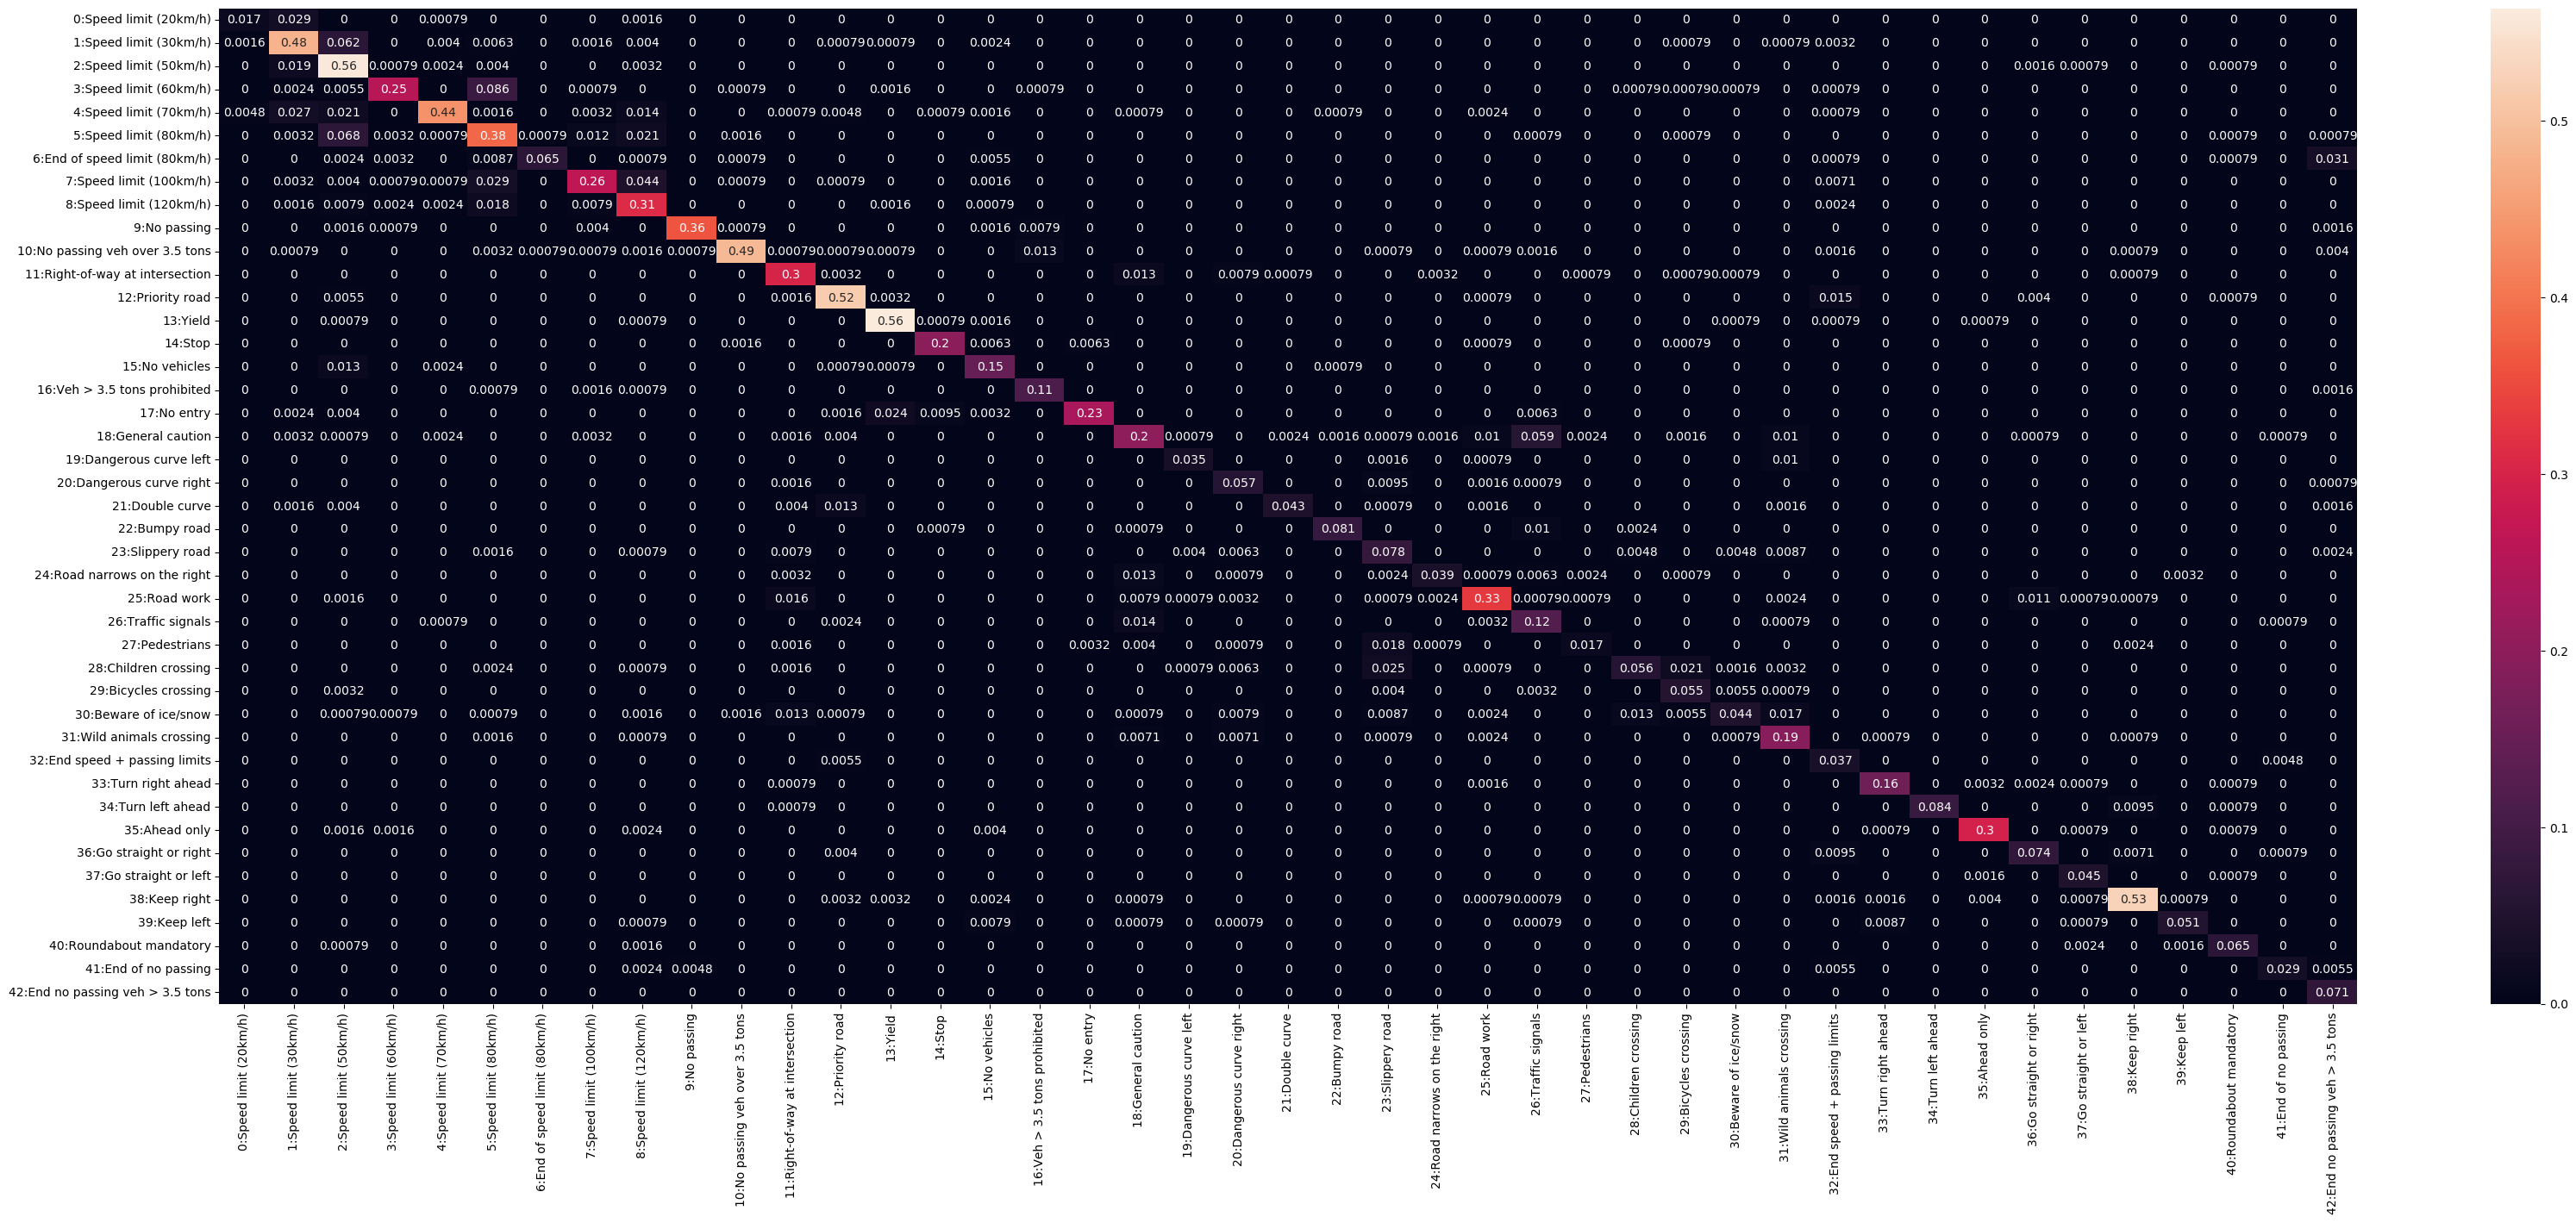

In [20]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons']))

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('ResNet50_confusion_matrix.png')

cf_report = classification_report(y_true, y_pred)
print(cf_report)
print(cf_matrix)


In [16]:
model.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [17]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classe
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82

Macro Precision: 0.78
Macro Recall: 0.75
Macro F1-score: 0.75

Weighted Precision: 0.83
Weighted Recall: 0.82
Weighted F1-score: 0.82


In [19]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons']))


Classification Report

                                  precision    recall  f1-score   support

          0:Speed limit (20km/h)       0.77      0.17      0.27        60
          1:Speed limit (30km/h)       0.72      0.89      0.80       720
          2:Speed limit (50km/h)       0.82      0.81      0.81       750
          3:Speed limit (60km/h)       0.85      0.80      0.83       450
          4:Speed limit (70km/h)       0.85      0.83      0.84       660
          5:Speed limit (80km/h)       0.62      0.76      0.68       630
   6:End of speed limit (80km/h)       0.92      0.72      0.81       150
         7:Speed limit (100km/h)       0.65      0.82      0.72       450
         8:Speed limit (120km/h)       0.78      0.63      0.70       450
                    9:No passing       0.88      0.93      0.90       480
 10:No passing veh over 3.5 tons       0.98      0.90      0.94       660
 11:Right-of-way at intersection       0.84      0.72      0.78       420
             

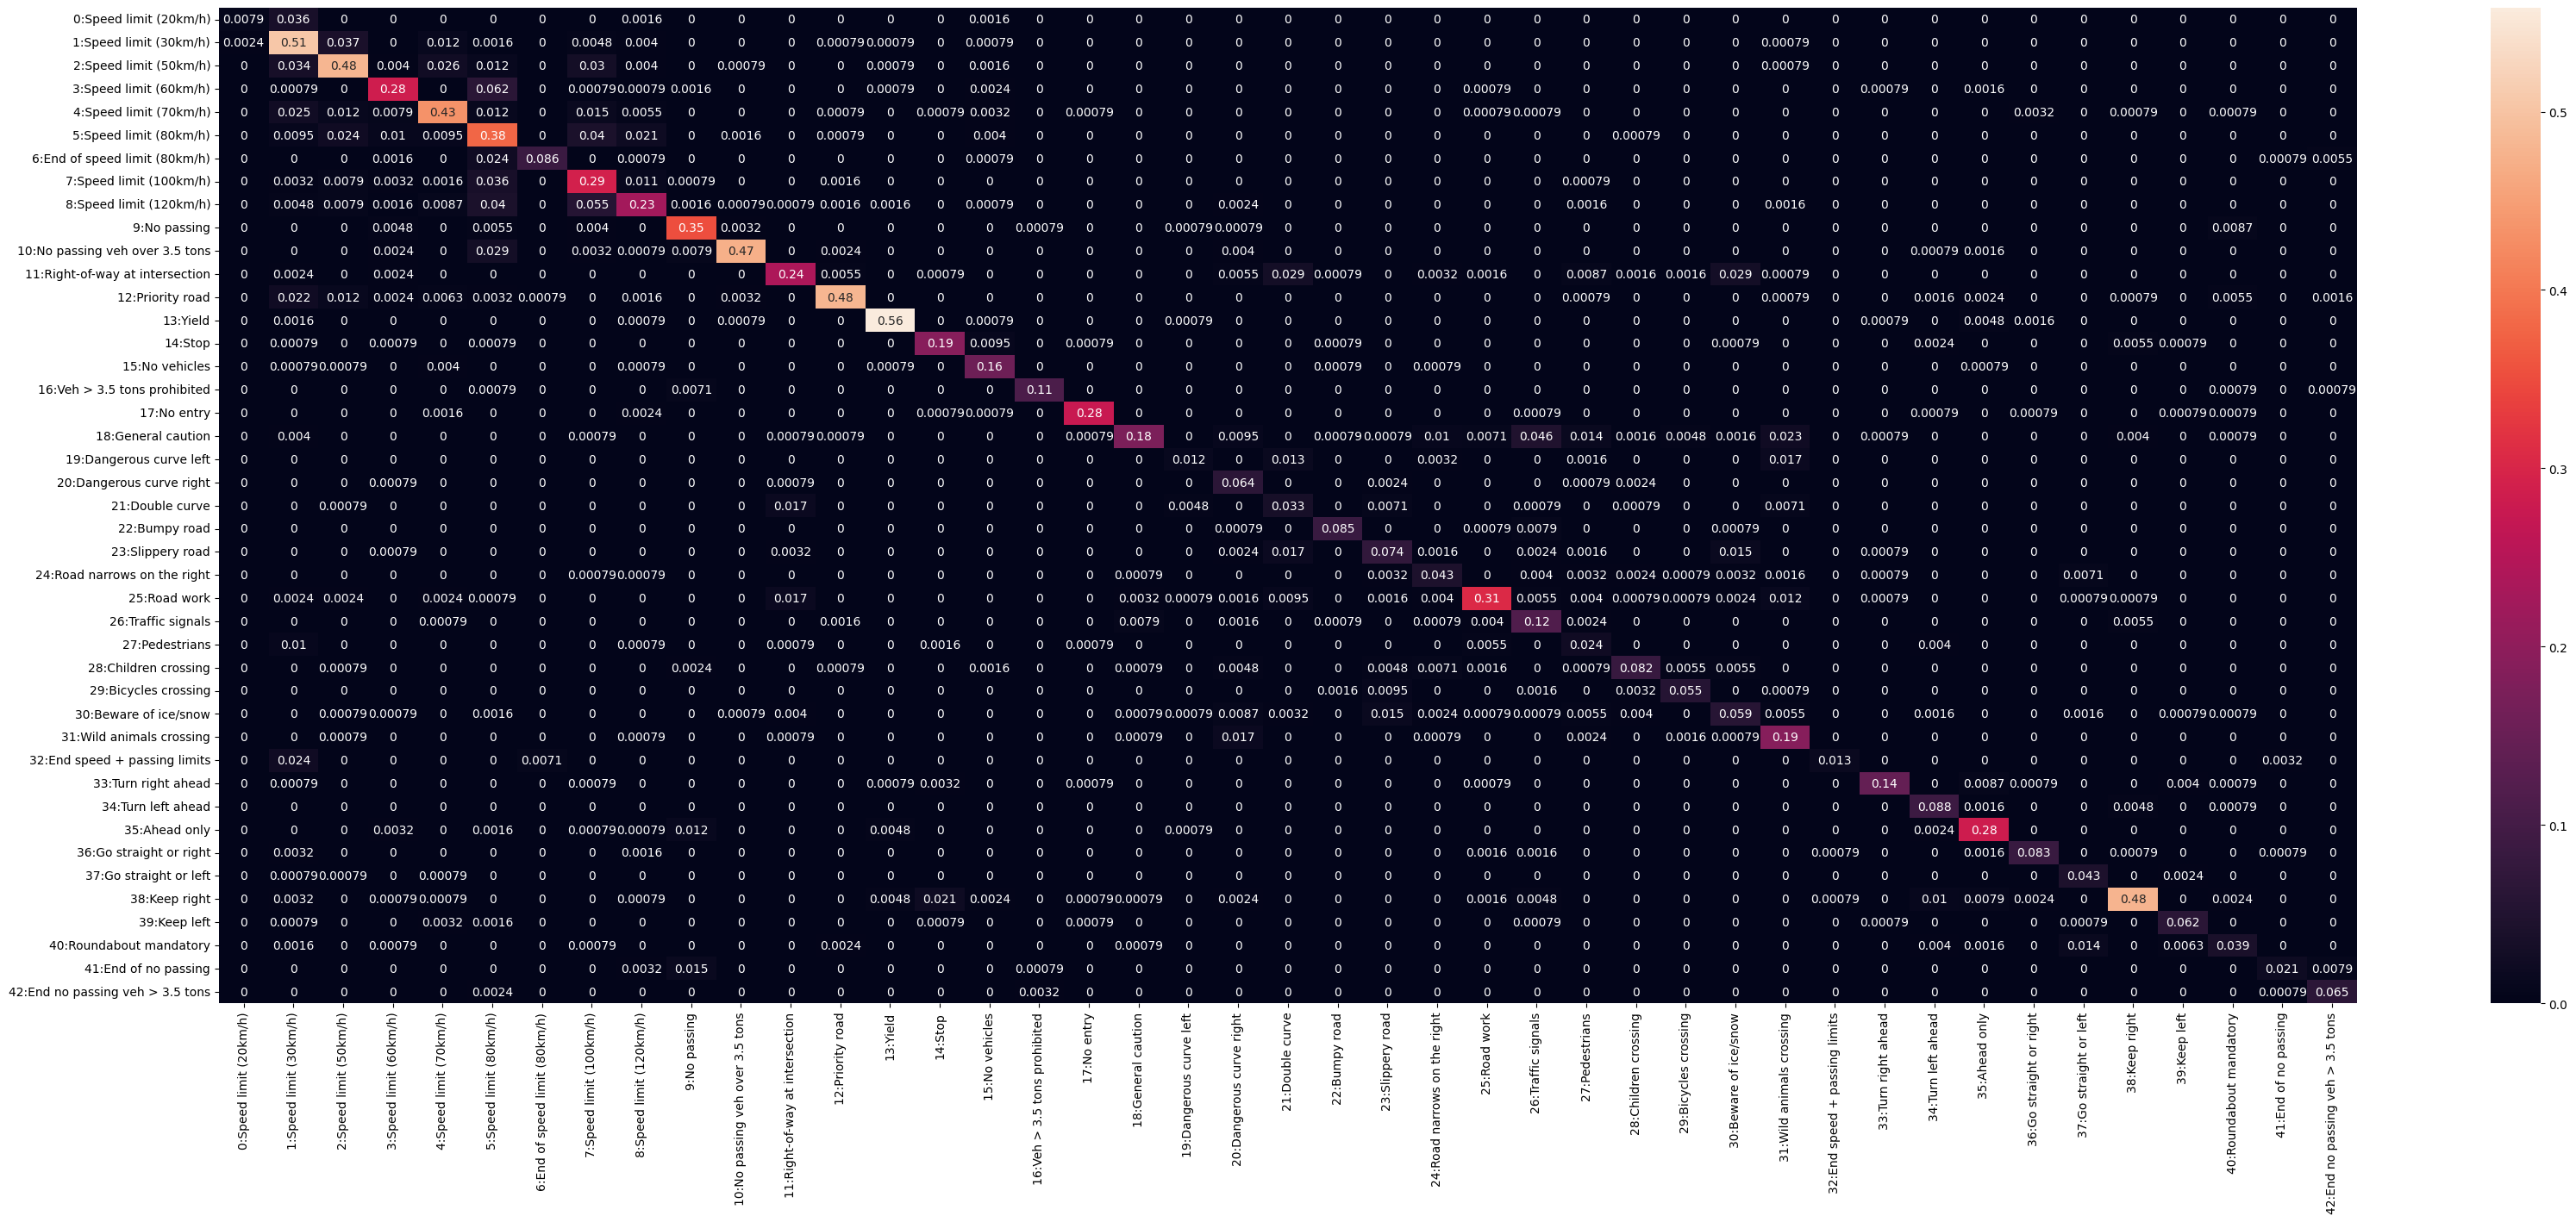

In [20]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('ResNet50_set3.png')

In [21]:
cf_report = classification_report(y_true, y_pred)
print(cf_report)

              precision    recall  f1-score   support

           0       0.77      0.17      0.27        60
           1       0.72      0.89      0.80       720
           2       0.82      0.81      0.81       750
           3       0.85      0.80      0.83       450
           4       0.85      0.83      0.84       660
           5       0.62      0.76      0.68       630
           6       0.92      0.72      0.81       150
           7       0.65      0.82      0.72       450
           8       0.78      0.63      0.70       450
           9       0.88      0.93      0.90       480
          10       0.98      0.90      0.94       660
          11       0.84      0.72      0.78       420
          12       0.96      0.88      0.92       690
          13       0.97      0.98      0.98       720
          14       0.87      0.89      0.88       270
          15       0.84      0.94      0.89       210
          16       0.96      0.92      0.94       150
          17       0.98    

In [22]:
print(cf_matrix)

[[ 10  46   0 ...   0   0   0]
 [  3 638  47 ...   0   0   0]
 [  0  43 606 ...   0   0   0]
 ...
 [  0   2   0 ...  49   0   0]
 [  0   0   0 ...   0  26  10]
 [  0   0   0 ...   0   1  82]]
